In [1]:
import torch
import pandas as pd
import time

from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import pickle
import seaborn as sns
from openfhe import *
from tqdm import tqdm

Setul de date este luat din kaggle: https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset-v2/data si este procesat in notebook-ul data/process_data.ipynb pentru usurinta.

Codul se poate rula integral prin optiunea "Run All" a notebook-ului

In [2]:
def load_data(path):
    saved_data = torch.load(path,weights_only=True)
    x_train = saved_data['train_data']
    x_test = saved_data['test_data']
    y_train = saved_data['train_labels']
    y_test = saved_data['test_labels']
    print("############# Data summary #############")
    print(f"x_train has shape: {x_train.shape}")
    print(f"y_train has shape: {y_train.shape}")
    print(f"x_test has shape: {x_test.shape}")
    print(f"y_test has shape: {y_test.shape}")
    print("#######################################")
    return x_train,x_test,y_train,y_test

Datele primite au valori mult prea diferite, de aceea ele trebuie normalizate pentru ca toate caracteristicile sa fie in intervale compatibile unele cu altele (i.e., varsta este in intervalul $[20, 100]$ si genul este in intervalul $[0, 1]$ $\Rightarrow$ ele trebuie aduse la un interval comun pentru a lucra cu ele).


In [3]:
def normalize_data(x_train,x_test,y_train,y_test):
    scaler = StandardScaler()
    x_train = torch.tensor(scaler.fit_transform(x_train), dtype=torch.float32)
    x_test= torch.tensor(scaler.transform(x_test), dtype=torch.float32)
    print(x_train.shape)
    print(x_test.shape)
    y_train = torch.tensor(scaler.fit_transform(y_train), dtype=torch.float32)
    y_test = torch.tensor(scaler.transform(y_test), dtype=torch.float32)
    return x_train,x_test,y_train,y_test


Setul de date este destul de mare, pentru a lucra mai usor dpdv al timpului si al memoriei o sa lucram cu un subset suficent de mare sa obtinem rezultate, dar suficient de mic pentru a putea fi procesat in limite decente de timp si memorie

In [4]:
x_train,x_test,y_train,y_test = load_data('../../data/date_liniar_regression.pth')
x_train,x_test,y_train,y_test = normalize_data(x_train,x_test,y_train,y_test)
x_train,x_test,y_train,y_test= x_train[:1000],x_test[:700],y_train[:1000],y_test[:700]
#vom lucra doar cu o parte din setul de date pentru a antrena mai repede modelul,
#  deoarce nu ne intereseaza acuratetea modelului 

############# Data summary #############
x_train has shape: torch.Size([24500, 16])
y_train has shape: torch.Size([24500, 1])
x_test has shape: torch.Size([10500, 16])
y_test has shape: torch.Size([10500, 1])
#######################################
torch.Size([24500, 16])
torch.Size([10500, 16])


algoritm preluat din documentatia oficiala https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html

In [5]:
class LinearRegressionFromScratch:
    def __init__(self, n_features, learning_rate=1e-2, weight_decay=0.01):
        self.bound = np.sqrt(3/n_features)
        self.weight = torch.tensor([0.01]*16)
        #se poate porni si de la weight-uri random 
        # self.weight =  torch.tensor(np.random.uniform(-self.bound, self.bound, size=n_features))
        self.bias = torch.tensor([0.000])
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self._delta_w = 0
        self._delta_b = 0
       
    def forward(self, x_data):
        #enc_x este un batch de date, shape : b,n_features
        return torch.tensor([torch.matmul(x, self.weight) + self.bias for x in x_data])

    def backward(self, enc_x, enc_out, enc_y):
        batch_size = len(enc_x)
        #calculam coborarea pe gradient pentru un batch de date
        delta_y = [(out - y) for out, y in zip(enc_out, enc_y)]
        delta_w = [ x * dy for dy, x in zip(delta_y, enc_x)]
        self._delta_w = sum(delta_w) * (2/batch_size)
        self._delta_b = sum(delta_y) * (2/batch_size)

        
    def update_parameters(self):
        self._delta_w *= self.learning_rate
        self._delta_w += self.weight_decay * self.weight
        self.weight -= self._delta_w
        
        self.bias -= self._delta_b * self.learning_rate
        self._delta_w = 0
        self._delta_b = 0


In [9]:
def save_model(model, file_path):
    pickle.dump(model, open(file_path, "wb"))

Antrenarea modelului are trei pasi esentiali:

1. **Forward**: se realizeaza propagarea datelor de intrare prin model pentru a obtine predictia. In cazul regresiei liniare, predictia $\hat{y}$ se calculeaza astfel:

$$
\hat{y} = \mathbf{w}^\top \mathbf{x} + b
$$

unde $\mathbf{w}$ este vectorul de ponderi, $\mathbf{x}$ este vectorul de intrare, iar $b$ este bias-ul.

2. **Backward**: se calculeaza eroarea si derivata functiei de pierdere in raport cu parametrii modelului. Pentru functia de pierdere MSE (mean squared error), avem:

$$
\mathcal{L} = \frac{1}{n} \sum_{i=1}^n (\hat{y}_i - y_i)^2
$$

Gradientii se calculeaza astfel:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{w}} = \frac{2}{n} \sum_{i=1}^n (\hat{y}_i - y_i) \cdot \mathbf{x}_i
$$

$$
\frac{\partial \mathcal{L}}{\partial b} = \frac{2}{n} \sum_{i=1}^n (\hat{y}_i - y_i)
$$

3. **Actualizarea parametrilor**: se foloseste o rata de invatare $\eta$ pentru a ajusta parametrii:

$$
\mathbf{w} \leftarrow \mathbf{w} - \eta \cdot \frac{\partial \mathcal{L}}{\partial \mathbf{w}}
$$

$$
b \leftarrow b - \eta \cdot \frac{\partial \mathcal{L}}{\partial b}
$$


epoch:  15%|█▌        | 3/20 [00:00<00:00, 24.57it/s]

Epoch 1, Loss: 0.9462548494338989
Epoch 2, Loss: 0.8213685750961304
Epoch 3, Loss: 0.7167863845825195
Epoch 4, Loss: 0.6291110515594482
Epoch 5, Loss: 0.5547208189964294


epoch:  50%|█████     | 10/20 [00:00<00:00, 27.30it/s]

Epoch 6, Loss: 0.4922634959220886
Epoch 7, Loss: 0.43898805975914
Epoch 8, Loss: 0.39395034313201904
Epoch 9, Loss: 0.35555166006088257
Epoch 10, Loss: 0.3227207660675049
Epoch 11, Loss: 0.29479554295539856
Epoch 12, Loss: 0.27098724246025085


epoch:  85%|████████▌ | 17/20 [00:00<00:00, 29.08it/s]

Epoch 13, Loss: 0.24997715651988983
Epoch 14, Loss: 0.23237812519073486
Epoch 15, Loss: 0.21693047881126404
Epoch 16, Loss: 0.2035132497549057
Epoch 17, Loss: 0.19173279404640198
Epoch 18, Loss: 0.18180713057518005
Epoch 19, Loss: 0.17307519912719727


epoch: 100%|██████████| 20/20 [00:00<00:00, 28.20it/s]


Epoch 20, Loss: 0.16529440879821777


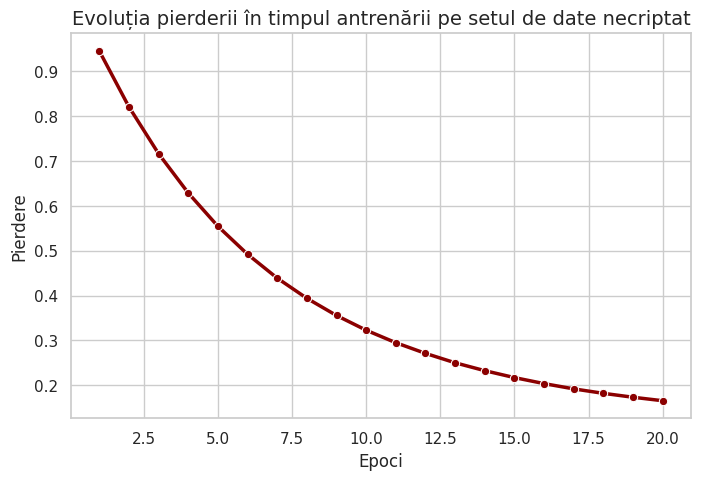

Antrenarea modelului pe date necriptate a durat:1.07573082400006114767 secunde


In [9]:
li_r_model = LinearRegressionFromScratch(n_features=x_train.shape[1])
t_start = time.perf_counter()
batch_size = 512
epochs = 20
loss_list =[]
for epoch in tqdm(range(epochs),desc="epoch"):
    #lua batch-uri din datele de train random
    indices = np.random.permutation(x_train.shape[0])
    epoch_data = [x_train[idx] for idx in indices]
    epoch_targets = [y_train[idx] for idx in indices]
    predictions = torch.tensor([])
    for batch in range(0, len(epoch_data),batch_size):
        batch_data = epoch_data[batch: batch+batch_size]
        batch_targets = epoch_targets[batch: batch+batch_size]
        #antrenarea porneste aici
        batch_out = li_r_model.forward(batch_data)
        li_r_model.backward(batch_data, batch_out, batch_targets)
        li_r_model.update_parameters()
        #se termina aici
        predictions= torch.cat((predictions , batch_out), dim=0) 
    #calcularea loss-uluo care trebuie sa scada
    loss = mean_squared_error(epoch_targets, predictions)
    loss_list.append(loss)
    print(f"Epoch {epoch+1}, Loss: {loss}")
sns.set_theme(style="whitegrid", palette="pastel")
plt.figure(figsize=(8, 5))
sns.lineplot(x=range(1, epochs + 1), y=loss_list, marker='o', linewidth=2.5, color="darkred")
plt.xlabel('Epoci', fontsize=12)
plt.ylabel('Pierdere', fontsize=12)
plt.title('Evoluția pierderii în timpul antrenării pe setul de date necriptat', fontsize=14)
plt.savefig('../../plots/liniar_regression/li_r_loss_curve_training_on_clear_data.png')
plt.show()

t_end = time.perf_counter()

print(f"Antrenarea modelului pe date necriptate a durat:{(t_end - t_start):.20f} secunde")

# save_model(li_r_model,'li_r_trained_on_clear_data.pkl')


In [7]:
def metric_on_clear_data(model, x, y):
    t_start = time.perf_counter()
    pred = model.forward(x)
    t_end = time.perf_counter()
    print(f"Predictiile pe testul de date necriptate au durat:{(t_end - t_start):.20f} secunde")

    r2 = r2_score(y, pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, pred, alpha=0.5, color='darkred', label='Predicții vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predicții perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predicții', fontsize=12)
    plt.title('Model antrenat pe date clare-Preziceri pe date clare', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.savefig("../../plots/liniar_regression/li_r_trained_on_clear_data_predictions_on_clear_data_openfhe.png")
    plt.show()
    return r2,mse

Predictiile pe testul de date necriptate au durat:0.00872594400004800264 secunde
R^2 Score = 0.8639
MSE = 0.1407


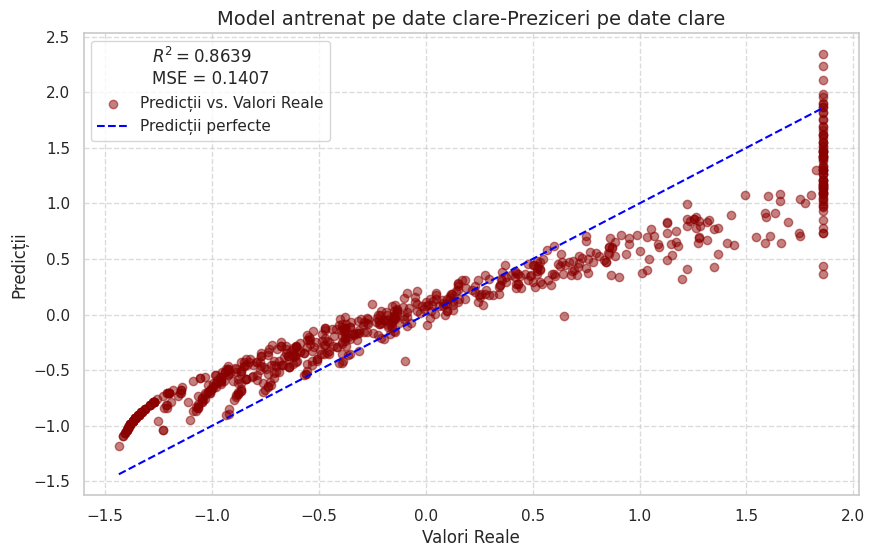

tensor([ 0.3189, -0.0557,  0.1322,  0.1800,  0.1007,  0.1076,  0.1000,  0.1003,
         0.0753,  0.0898,  0.0503,  0.0673,  0.1012,  0.0774,  0.1156,  0.0423])
tensor([0.0121])


In [10]:
# li_r_model = pickle.load(open("./li_r_trained_on_clear_data.pkl", 'rb'))
r2_clear_data, mse_clear_data=metric_on_clear_data(li_r_model,x_test,y_test)
print(li_r_model.weight)
print(li_r_model.bias)

In [16]:
def feature_importance(model, feature_names):
    weights = model.weight

    weights = torch.abs(weights)
    weights = weights / torch.sum(weights)

    sorted_indices = torch.argsort(weights)
    feature_names_sorted = [feature_names[i] for i in sorted_indices]
    weights_sorted = weights[sorted_indices]

    plt.figure(figsize=(16, 6))
    sns.barplot(y=feature_names_sorted, x=weights_sorted, hue=feature_names_sorted, palette="Reds", orient="h", legend=False)

    plt.xlabel('Importanța caracteristicilor', fontsize=12)
    plt.ylabel('Caracteristici', fontsize=12)
    plt.title('Grafic de importanța caracteristicilor- model antrenat pe date clare', fontsize=14)

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("../../plots/liniar_regression/li_r_trained_on_clear_data_feature_importance.png")
    plt.show()



['Age', 'Gender', 'Chest Pain', 'High Blood Pressure', 'Irregular Heartbeat', 'Shortness Of Breath', 'Fatigue Weakness', 'Dizziness', 'Swelling Edema', 'Neck Jaw Pain', 'Excessive Sweating', 'Persistent Cough', 'Chest Discomfort', 'Cold Hands Feet', 'Snoring Sleep Apnea', 'Anxiety Doom']


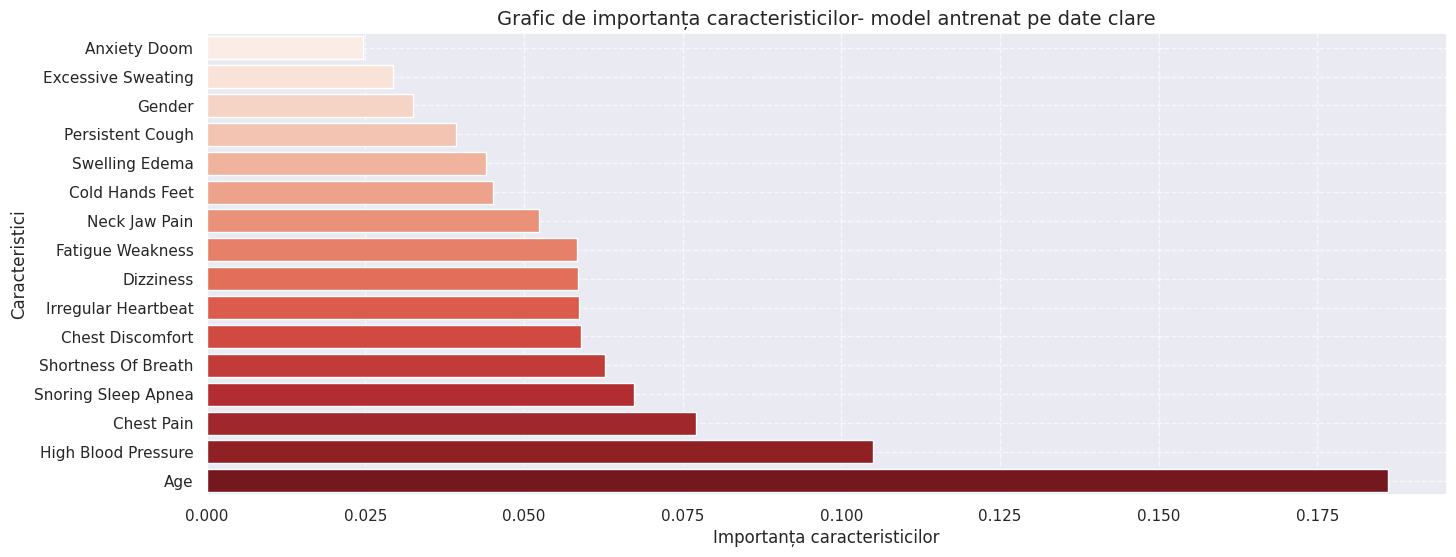

In [19]:
csv = pd.read_csv('../../data/stroke_risk_dataset.csv')
csv = csv.drop(columns=["stroke_risk_percentage", "at_risk", "nausea_vomiting"])
header = csv.columns.tolist()

formatted_features = [feat.replace('_', ' ').title() for feat in header]
print(formatted_features)
feature_importance(li_r_model,formatted_features) 

**Preziceri pe date criptate**

In openfhe exista mai multe security levels care pot fi setate, default este :
**HEStd_128_classic = <SecurityLevel.HEStd_128_classic: 0>**
O sa extragem metrici pentru mai multi parametrii de SetSecurityLevel pentru a vedea cum afecteaza dimensiunea inelului si gradul de securitate timpul si acuratetea procesarii datelor

In [25]:
table_list = []

In [11]:
multDepth = 2
scaleModSize = 40
batchSize = len(x_test[1]) #16
parameters = CCParamsCKKSRNS()
parameters.SetMultiplicativeDepth(multDepth)
parameters.SetScalingModSize(scaleModSize)
parameters.SetBatchSize(batchSize)
parameters.SetRingDim(4096)
parameters.SetSecurityLevel(HEStd_NotSet)

cc = GenCryptoContext(parameters)

cc.Enable(PKE)
cc.Enable(KEYSWITCH)
cc.Enable(LEVELEDSHE)
cc.Enable(ADVANCEDSHE)
ring_dim = cc.GetRingDimension()
print(f"Dimensiunea inelului in CKKS {ring_dim}")
security_param= parameters.GetSecurityLevel()
print(f"Parametrul de securitate: {security_param}")
keys = cc.KeyGen()

#asigura ca evaluarea datelor criptate se face fara decriptatea lor
#cheile sunt derivate din secret key
cc.EvalMultKeyGen(keys.secretKey)
cc.EvalSumKeyGen(keys.secretKey)


Dimensiunea inelului in CKKS 4096
Parametrul de securitate: SecurityLevel.HEStd_NotSet


In [12]:
#x_test nu are o forma buna pentru biblioteca openfhe
print(x_test.shape)
x_test_list = x_test[:700].tolist() 
print(x_test_list[:2])
print(type(x_test_list[0]))

torch.Size([700, 16])
[[-0.4856494069099426, -1.00515615940094, -0.4117799401283264, 1.7292275428771973, -0.3283218741416931, -0.48778727650642395, -0.5707517862319946, -0.4851568639278412, -0.41272860765457153, -0.3342396318912506, 3.038736343383789, -0.343669593334198, 2.4405479431152344, -0.4890051484107971, -0.4168514609336853, -0.33037757873535156], [1.2492173910140991, 0.9948703050613403, -0.4117799401283264, 1.7292275428771973, 3.0457913875579834, 2.0500738620758057, 1.7520751953125, 2.0611891746520996, -0.41272860765457153, -0.3342396318912506, -0.3290841579437256, 2.90977144241333, 2.4405479431152344, 2.0449681282043457, -0.4168514609336853, -0.33037757873535156]]
<class 'list'>


In [13]:
def encrypt_vec():
    enc_list=[]
    for x_t_l in tqdm(x_test_list, desc="criptare date"):
        x_test_encoded = cc.MakeCKKSPackedPlaintext(x_t_l)
        enc_x_test = cc.Encrypt(keys.publicKey, x_test_encoded)
        enc_list.append(enc_x_test)
    return enc_list

In [14]:
t_start = time.perf_counter()
enc_test_list = encrypt_vec()
t_end = time.perf_counter()
print(f"Criptarea pe setul de date de test a durat {(t_end - t_start):.20f} secunde")

criptare date: 100%|██████████| 700/700 [00:07<00:00, 88.12it/s] 

Criptarea pe setul de date de test a durat 7.94811487100002977968 secunde


Functia `forward` din clasa `LinearRegressionFromScratch` nu mai functioneaza pentru predictiile pe datele criptate, deoarece OpenFHE are propriile functii de adunare si inmultire, care trebuie sa respecte anumiti parametri specifici criptarii homomorfe.

Din acest motiv, atat ponderile (weights) cat si bias-ul trebuie **encodate** inainte de a fi utilizate in operatii pe date criptate.


In [15]:
def forward_on_encrypted_data(model,enc_x):
    weight = model.weight.tolist()
    bias = model.bias.tolist()
    #encode weight si bias
    encoded_weights = cc.MakeCKKSPackedPlaintext(weight)
    encoded_bias = cc.MakeCKKSPackedPlaintext(bias)
    enc_sum = cc.EvalInnerProduct(enc_x, encoded_weights,16)
    enc_pred = cc.EvalAdd(enc_sum, encoded_bias)
    return enc_pred

In [16]:
def metrics_on_encrypted_data(model, enc_x, y):
    #predictiile sunt se vor intoarce criptate
    enc_list_pred = []
    t_start = time.perf_counter()
    for e_x in tqdm(enc_x, desc="Predictii"):
        pred = forward_on_encrypted_data(li_r_model,e_x)
        enc_list_pred.append(pred)
    t_end = time.perf_counter()
    t_pred = t_end - t_start
    print(f"Predictiile pe testul de date criptat au durat:{(t_end - t_start):.20f} secunde")
    # return enc_list_pred[0]
    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    t_start = time.perf_counter()
    for enc_pred in enc_list_pred:
        decript = cc.Decrypt(enc_pred, keys.secretKey)
        decript.SetLength(1)
        decoded_values = decript.GetCKKSPackedValue()
        list_pred.append(decoded_values[0].real)
    t_end = time.perf_counter()
    t_decrip_pred = t_end - t_start
    print(f"Decriptarea predictiilor a durat:{(t_end - t_start):.20f} secunde")
    
    print(list_pred[0])
    y = y.detach().numpy()
    r2 = r2_score(y, list_pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, list_pred)
    print(f"MSE = {mse:.4f}")

    plt.figure(figsize=(10, 6))
    plt.scatter(y, list_pred, alpha=0.5, color='darkred', label='Predictii vs. Valori Reale')
    plt.plot([min(y), max(y)], [min(y), max(y)], color='blue', linestyle='--', label='Predictii perfecte')
    plt.xlabel('Valori Reale', fontsize=12)
    plt.ylabel('Predictii', fontsize=12)
    plt.legend(title=f'$R^2 = {r2:.4f}$\nMSE = {mse:.4f}', title_fontsize=12)
    plt.title('Model antrenat pe date clare-Preziceri pe date criptate', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("../../plots/liniar_regression/li_r_trained_on_clear_data_predictions_on_encrypted_data_openfhe.png")
    plt.show()
    return r2
  
    

Predictii: 100%|██████████| 700/700 [00:20<00:00, 34.06it/s]


Predictiile pe testul de date criptat au durat:20.55757878100007474131 secunde
Decriptarea predictiilor a durat:2.33395044999997480772 secunde
0.19408133771173378
R^2 Score = 0.8639
MSE = 0.1407


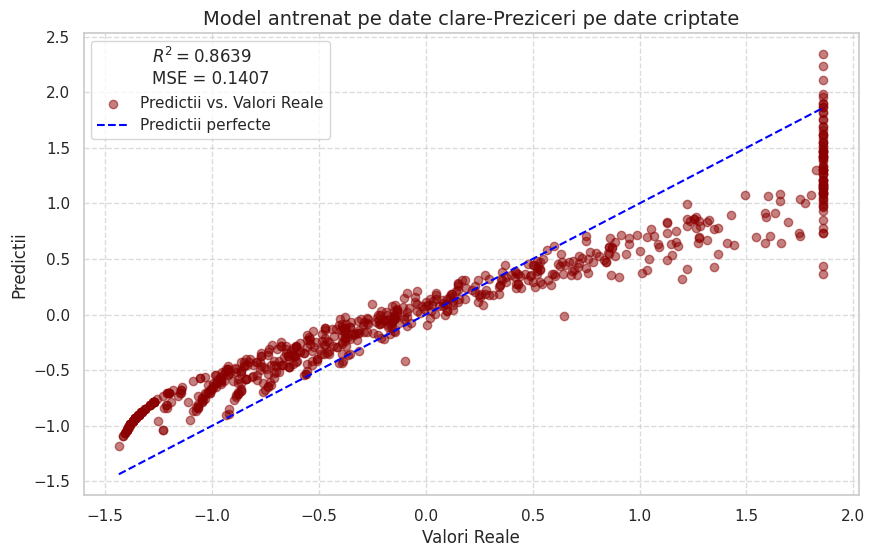

In [17]:
r2 = metrics_on_encrypted_data(li_r_model,enc_test_list,y_test)

se vede ca diferenta de precizie este inexistenta intre prezicerile pe date clare si cele pe date criptate

in continuare vom vedea cum criptarea poate sa influenteze precizia si intre ce valori se situeaza de fapt precizia pe datele de test 


In [ ]:
def interval_de_precizie(model, enc_x, y):
     #predictiile sunt se vor intoarce criptate
    enc_list_pred = []
    t_start = time.perf_counter()
    for e_x in tqdm(enc_x, desc="Predictii"):
        pred = forward_on_encrypted_data(model,e_x)
        enc_list_pred.append(pred)
    t_end = time.perf_counter()
    t_pred = t_end - t_start
    print(f"Predictiile pe testul de date criptat au durat:{(t_end - t_start):.20f} secunde")
   
    #trebuie decriptate pentru a calcula metricile
    list_pred = []
    t_start = time.perf_counter()
    for enc_pred in enc_list_pred:
        decript = cc.Decrypt(enc_pred, keys.secretKey)
        decript.SetLength(1)
        decoded_values = decript.GetCKKSPackedValue()
        list_pred.append(decoded_values[0].real)
    t_end = time.perf_counter()
    t_dec_pred = t_end - t_start
    print(f"Decriptarea predictiilor a durat:{(t_end - t_start):.20f} secunde")
    
    y = y.detach().numpy()
    r2 = r2_score(y, list_pred)
    print(f"R^2 Score = {r2:.4f}")
    mse =  mean_squared_error(y, list_pred)
    print(f"MSE = {mse:.4f}")
    return r2, mse, t_pred, t_dec_pred

In [ ]:
mse_list = []
r2_list = []
sum_timp_criptare = 0
sum_timp_pred = 0
sum_timp_dec_pred =0
for incercari in range(5):
    t_start = time.perf_counter()
    enc_x_test = encrypt_vec()
    t_end = time.perf_counter()
    t_cript = t_end-t_start
    sum_timp_criptare +=t_cript
    r2,mse,t_pred, t_dec_pred = interval_de_precizie(li_r_model,enc_x_test,y_test[:700])
    sum_timp_pred +=t_pred
    sum_timp_dec_pred += t_dec_pred
    mse_list.append(mse)
    r2_list.append(r2)

avg_timp_criptare = sum_timp_criptare/5
avg_timp_pred = sum_timp_pred/5
avg_timp_dec_pred = sum_timp_dec_pred /5

In [ ]:
data = {
    'Iterație': [i for i in range(5)],
    'R2 Date Criptat': r2_list,
    'R2 Date clare': [r2_clear_data] * 5, 
}

df = pd.DataFrame(data)

plt.figure(figsize=(10, 6))

sns.lineplot(data=df, x='Iterație', y='R2 Date Criptat', label='R2 date criptate', marker='o', color='red')
sns.lineplot(data=df, x='Iterație', y='R2 Date clare', label='R2 date clare', marker='x', color='orange')


plt.title('Variația R2 în cele 5 criptări de date')
plt.xlabel('Iterație')
plt.ylabel('Valori')

y_ticks = [ 0.85,0.851,0.852,0.853,0.854,0.855,0.856,0.859]
plt.yticks(y_ticks)

plt.ylim(0.849, 0.859)  

plt.legend()

plt.savefig("li_r_trained_on_clear_data_variance_predictions_on_encrypted_data.png")

plt.show()
    

In [ ]:
# (security_param,ring_dim,avg_timp_criptare,avg_timp_pred,avg_timp_dec_pred,r2)

(<SecurityLevel.HEStd_128_classic: 0>,
 16384,
 12.626807427800667,
 49.710884650399386,
 8.885370516202238,
 0.8281465457088487)

In [ ]:
# table_list.append((security_param,ring_dim,avg_timp_criptare,avg_timp_pred,avg_timp_dec_pred,r2))
# print(table_list)